In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

# Zillow

Data provided by Zillow * Kaggle (see [here](https://www.kaggle.com/pratyushakar/zillow-zestimate#properties_2017.csv))

In [2]:
data_url = "https://docs.google.com/spreadsheets/d/198EG3tckqzD1uOKSYxAY62i5v_0LIZQMgzaIae6u1vo/export?format=csv"

<IPython.core.display.Javascript object>

Load all the usual suspects and some new ones including: `AgglomerativeClustering`, `DBSCAN`, `dendrogram`.

In [55]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, DBSCAN

from scipy.cluster.hierarchy import dendrogram
from scipy.spatial.distance import pdist, squareform

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

<IPython.core.display.Javascript object>

Function that will also be used in your exercise to produce a dendrogram from our `AgglomerativeClustering` object.

In [4]:
def plot_dendrogram(model, **kwargs):
    """
    A function for plotting a dendrogram. Sourced from the following link:
    https://github.com/scikit-learn/scikit-learn/blob/70cf4a676caa2d2dad2e3f6e4478d64bcb0506f7/examples/cluster/plot_hierarchical_clustering_dendrogram.py
    
    Parameters:
        model (object of class sklearn.cluster.hierarchical.AgglomerativeClustering): a fitted scikit-learn hierarchical clustering model.
    
    Output: a dendrogram based on the model based in the parameters.
    
    Returns: None   
    """
    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0] + 2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(
        float
    )

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

<IPython.core.display.Javascript object>

Read data and do some inspection & cleaning.

In [5]:
zillow = pd.read_csv(data_url)
zillow.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,17291058,NaN,NaN,8516.0,9.5,6,NaN,NaN,9.5,66.0,...,2.0,NaN,12956457,26879210,2016,13922753,283062.46,NaN,NaN,6.111007e+13
1,17214945,NaN,NaN,296.0,2.5,3,NaN,NaN,2.5,66.0,...,2.0,NaN,321000,1074000,2016,753000,11525.74,NaN,NaN,6.111005e+13
2,17060678,NaN,NaN,1146.0,6.5,4,NaN,NaN,6.5,66.0,...,2.0,NaN,1804157,2275709,2016,471552,24503.28,NaN,NaN,6.111001e+13
3,17284901,NaN,NaN,2322.0,1.5,6,NaN,NaN,1.5,66.0,...,3.0,NaN,4481348,7138171,2016,2656823,75722.34,NaN,NaN,6.111007e+13
4,17277746,NaN,NaN,182.0,3.5,4,NaN,NaN,3.5,66.0,...,2.0,NaN,254934,420023,2016,165089,4427.28,NaN,NaN,6.111006e+13


<IPython.core.display.Javascript object>

In [6]:
zillow.shape

(15000, 58)

<IPython.core.display.Javascript object>

Drop columns that have more than 20% of their values missing.  How many columns does this remove?

In [7]:
zillow_mask = zillow.isna().mean()
drop = zillow_mask[zillow_mask > 0.2].index
print(f"Dropping {len(drop)} columns")

zillow = zillow.drop(columns=drop)

Dropping 24 columns


<IPython.core.display.Javascript object>

Drop all NAs from the dataframe.  How many rows does this remove?

In [8]:
og_nrows = zillow.shape[0]
zillow = zillow.dropna()
new_nrows = zillow.shape[0]

print(f"Dropping {og_nrows  - new_nrows} rows")

Dropping 2575 rows


<IPython.core.display.Javascript object>

For the sake of time & plotting, downsample to 100 random records in the `zillow` dataframe.  Use a random seed of `42` to obtain consistent results.

In [9]:
# If we calc a distance matrix it will be 12425 * 12425 (154,380,625) elements large
# Let's down sample to have a quicker demo and a prettier dendrogram to look at
zillow = zillow.sample(100, random_state=42)
zillow.shape

(100, 34)

<IPython.core.display.Javascript object>

Dropping a lot of columns based on being ID, having 0 variance, or being collinear (based on my understanding... rather than analysis... might be wrong).

In [10]:
# Id columns aren"t too useful for clustering but we might want it later
# fmt: off
id_cols = ["parcelid", "pooltypeid7", "propertycountylandusecode", 
           "propertylandusetypeid", "regionidcity", "regionidcounty", "regionidzip",
           "latitude", "longitude", "fips",
           "rawcensustractandblock", "censustractandblock"]
# fmt: on
zillow_sub = zillow.drop(columns=id_cols)

# Some columns that duplicate info
# Idk much about real estate so some of these might be bad assumptions
# fmt: off
dup_cols = ["calculatedbathnbr", "finishedsquarefeet50", "finishedsquarefeet12",
            "finishedfloor1squarefeet", "structuretaxvaluedollarcnt", 
            "taxvaluedollarcnt", "landtaxvaluedollarcnt"]
# fmt: on
zillow_sub = zillow_sub.drop(columns=dup_cols)

# That sample ends up with poolcnt and assessmentyear having 0 variance
no_var_cols = ["poolcnt", "assessmentyear"]
zillow_sub = zillow_sub.drop(columns=no_var_cols)

zillow_sub.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,lotsizesquarefeet,poolsizesum,roomcnt,yearbuilt,numberofstories,taxamount
11325,4.0,5,3705,2.0,4.0,4.0,948.0,59349.0,684.0,10,2001.0,2.0,15108.92
1766,3.0,5,3642,2.0,3.0,2.0,471.0,7720.0,640.0,10,1998.0,2.0,8078.32
14591,3.0,3,2779,2.0,3.0,2.0,659.0,11610.0,420.0,8,1988.0,2.0,7340.82
14939,3.0,3,2902,2.0,3.0,3.0,774.0,43560.0,525.0,7,1977.0,2.0,11795.98
12049,3.0,4,2295,2.0,3.0,2.0,487.0,8539.0,396.0,8,1979.0,2.0,4799.22


<IPython.core.display.Javascript object>

In [11]:
# zillow_sub.boxplot(rot=90, figsize=(6, 4))
# plt.show()

<IPython.core.display.Javascript object>

In [12]:
# zillow_sub["lotsizesquarefeet"] = np.log(zillow_sub["lotsizesquarefeet"])

<IPython.core.display.Javascript object>

In [13]:
# zillow_sub.boxplot(rot=90, figsize=(6, 4))
# plt.show()

<IPython.core.display.Javascript object>

## Heirarchical Clustering

In [14]:
# Dropping outlier rows (determined by agg clustering)
# drop_rows = [378, 6365, 229, 4086, 1541, 1845, 8068, 12753, 2869, 2153]

# zillow_sub = zillow_sub.drop(columns=["label"], errors="ignore")
# zillow_sub = zillow_sub.drop(labels=drop_rows, errors="ignore")

<IPython.core.display.Javascript object>

Prep data for clustering

In [15]:
scaler = StandardScaler()
scaled = scaler.fit_transform(zillow_sub)

<IPython.core.display.Javascript object>

Calculate distance matrix using euclidean distance

In [16]:
dist_mat = squareform(pdist(scaled, metric="euclid"))

<IPython.core.display.Javascript object>

Perform heirarchical clustering with the distance matrix and [`sklearn.cluster.AgglomerativeClustering`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html).

In [17]:
clst = AgglomerativeClustering(n_clusters=5, linkage="ward", affinity="euclidean")
clst.fit(scaled)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=5)

<IPython.core.display.Javascript object>

Use the `plot_dendrogram()` helper function to plot the heirarchical clusters.

In [18]:
# plt.figure(figsize=(20, 10))
# plot_dendrogram(clst)

<IPython.core.display.Javascript object>

Assign the cluster labels to a column in our original dataframe.

In [19]:
zillow_sub["label"] = clst.labels_
zillow_sub.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,lotsizesquarefeet,poolsizesum,roomcnt,yearbuilt,numberofstories,taxamount,label
11325,4.0,5,3705,2.0,4.0,4.0,948.0,59349.0,684.0,10,2001.0,2.0,15108.92,1
1766,3.0,5,3642,2.0,3.0,2.0,471.0,7720.0,640.0,10,1998.0,2.0,8078.32,3
14591,3.0,3,2779,2.0,3.0,2.0,659.0,11610.0,420.0,8,1988.0,2.0,7340.82,4
14939,3.0,3,2902,2.0,3.0,3.0,774.0,43560.0,525.0,7,1977.0,2.0,11795.98,4
12049,3.0,4,2295,2.0,3.0,2.0,487.0,8539.0,396.0,8,1979.0,2.0,4799.22,4


<IPython.core.display.Javascript object>

Interpret the clusters

In [20]:
zillow_sub["label"].value_counts()

0    35
4    25
3    23
1    15
2     2
Name: label, dtype: int64

<IPython.core.display.Javascript object>

In [21]:
# Isolate onsie/twosie clusters to drop and re-cluster
drop_rows = zillow_sub[~zillow_sub["label"].isin([0, 1])].index

<IPython.core.display.Javascript object>

In [22]:
cluster_desc = zillow_sub.groupby("label").mean()
cluster_desc.sort_values(["bathroomcnt", "bedroomcnt"])

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,lotsizesquarefeet,poolsizesum,roomcnt,yearbuilt,numberofstories,taxamount
label,,,,,,,,,,,,,
4,2.680000,3.800000,2385.440000,1.480000,2.360000,2.080000,552.960000,10235.320000,460.000000,7.560000,1976.400000,2.000000,5085.256800
0,2.685714,3.685714,2429.400000,1.342857,2.371429,2.085714,543.371429,22888.542857,546.142857,7.542857,1976.285714,1.000000,7355.421143
3,3.630435,4.695652,3432.304348,2.086957,3.304348,2.000000,630.173913,16227.260870,529.434783,9.043478,1993.000000,2.000000,9598.466957
1,4.633333,4.266667,4697.266667,2.266667,4.266667,3.800000,1005.933333,94056.400000,650.133333,9.400000,1995.200000,1.666667,16415.148000
2,7.250000,6.000000,12733.500000,4.000000,7.000000,7.000000,1863.500000,78844.000000,700.000000,16.500000,1999.000000,2.000000,56187.890000


<IPython.core.display.Javascript object>

## DBSCAN Clustering

Perform clustering with [`sklearn.cluster.DBSCAN`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html).

In [87]:
clst = DBSCAN(eps=2.0, min_samples=2, metric="precomputed")
clst.fit(dist_mat)

DBSCAN(algorithm='auto', eps=2.0, leaf_size=30, metric='precomputed',
       metric_params=None, min_samples=2, n_jobs=None, p=None)

<IPython.core.display.Javascript object>

Assign the labels to the dataframe

In [88]:
zillow_sub["label"] = clst.labels_
zillow_sub["label"].value_counts()

 0    47
 1    25
-1    22
 4     2
 3     2
 2     2
Name: label, dtype: int64

<IPython.core.display.Javascript object>

In [52]:
cluster_df = zillow_sub[zillow_sub["label"] != -1]
cluster_summary = cluster_df.groupby("label").mean()
cluster_summary

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,lotsizesquarefeet,poolsizesum,roomcnt,yearbuilt,numberofstories,taxamount
label,,,,,,,,,,,,,
0,3.034091,4.136364,2798.090909,1.704545,2.727273,2.045455,582.363636,11593.045455,489.727273,8.136364,1983.454545,2.0,6918.925000
1,2.386364,3.727273,2006.590909,1.136364,2.136364,2.000000,489.636364,15960.681818,516.727273,7.318182,1971.045455,1.0,5255.057273


<IPython.core.display.Javascript object>

In [73]:
clst_sum_tall = cluster_summary.T
clst_sum_tall["diff"] = clst_sum_tall[0] - clst_sum_tall[1]
clst_sum_tall["perc_diff"] = clst_sum_tall["diff"] / clst_sum_tall[0]
clst_sum_tall["abs_perc_diff"] = clst_sum_tall["perc_diff"].abs()
clst_sum_tall = clst_sum_tall.sort_values("abs_perc_diff", ascending=False)

display(clst_sum_tall)

biggest_diffs = clst_sum_tall.head().index

label,0,1,diff,perc_diff,abs_perc_diff
numberofstories,2.000000,1.000000,1.000000,0.500000,0.500000
lotsizesquarefeet,11593.045455,15960.681818,-4367.636364,-0.376746,0.376746
fireplacecnt,1.704545,1.136364,0.568182,0.333333,0.333333
calculatedfinishedsquarefeet,2798.090909,2006.590909,791.500000,0.282871,0.282871
taxamount,6918.925000,5255.057273,1663.867727,0.240481,0.240481
fullbathcnt,2.727273,2.136364,0.590909,0.216667,0.216667
bathroomcnt,3.034091,2.386364,0.647727,0.213483,0.213483
garagetotalsqft,582.363636,489.636364,92.727273,0.159226,0.159226
roomcnt,8.136364,7.318182,0.818182,0.100559,0.100559
bedroomcnt,4.136364,3.727273,0.409091,0.098901,0.098901


<IPython.core.display.Javascript object>

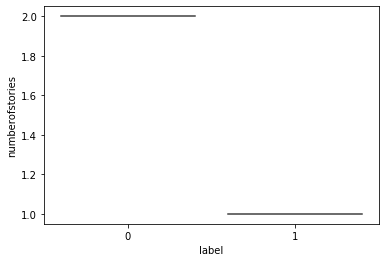

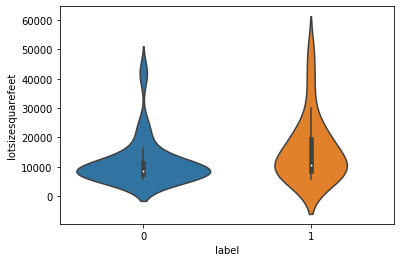

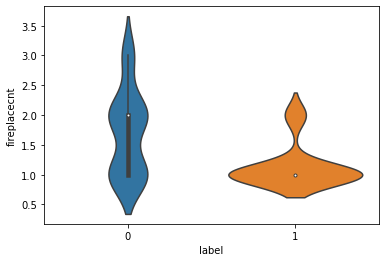

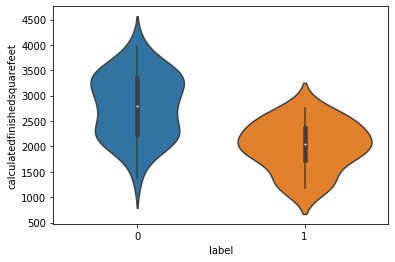

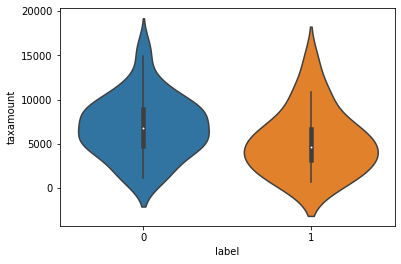

<IPython.core.display.Javascript object>

In [76]:
for column in biggest_diffs:
    sns.violinplot("label", column, data=cluster_df)
    plt.show()

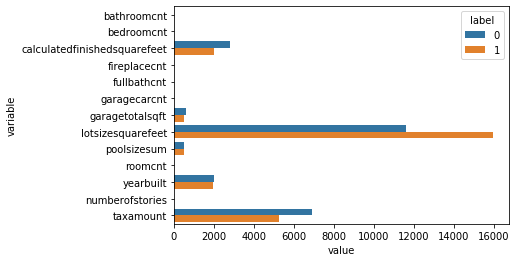

<IPython.core.display.Javascript object>

In [58]:
barplot_df = pd.melt(cluster_summary_lab, "label")

sns.barplot("value", "variable", hue="label", data=barplot_df)
plt.show()

In [59]:
barplot_df

,label,variable,value
0,0,bathroomcnt,3.034091
1,1,bathroomcnt,2.386364
2,0,bedroomcnt,4.136364
3,1,bedroomcnt,3.727273
4,0,calculatedfinishedsquarefeet,2798.090909
5,1,calculatedfinishedsquarefeet,2006.590909
6,0,fireplacecnt,1.704545
7,1,fireplacecnt,1.136364
8,0,fullbathcnt,2.727273
9,1,fullbathcnt,2.136364


<IPython.core.display.Javascript object>